## Group 5 - Gold Price Forcasting

In [1]:
# Importing the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smf
%matplotlib inline
import matplotlib.pylab
from matplotlib import pylab
import scipy.stats as stats
import datetime
import sklearn
import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# getting the data into a DataFrame.
data=pd.read_csv("Gold_data.csv",parse_dates = ['date'])

In [3]:
data

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75
...,...,...
2177,2021-12-17,4394.40
2178,2021-12-18,4389.50
2179,2021-12-19,4389.50
2180,2021-12-20,4354.10


In [4]:
data.tail(10)

,date,price
2172,2021-12-12,4333.5
2173,2021-12-13,4351.4
2174,2021-12-14,4328.2
2175,2021-12-15,4348.7
2176,2021-12-16,4399.8
2177,2021-12-17,4394.4
2178,2021-12-18,4389.5
2179,2021-12-19,4389.5
2180,2021-12-20,4354.1
2181,2021-12-21,4346.5


## Read Data  <a name="read-data"></a>
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [5]:
indexdata = data.set_index(['date'])
indexdata.head(5)

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2182 non-null   datetime64[ns]
 1   price   2182 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


In [7]:
#Data Structure 
data.shape

(2182, 2)

In [8]:
data.isnull().sum()

date     0
price    0
dtype: int64

In [9]:
data.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


In [10]:
#Count of duplicated rows
data[data.duplicated()].shape

(0, 2)

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,2182.0,3284.450046,719.564434,2252.6,2697.02,2879.8,4147.325,4966.3


<AxesSubplot:xlabel='price'>

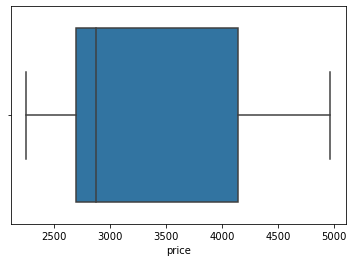

In [12]:
# Box Plot For checking the Outliers
sns.boxplot(data['price'])

In [13]:
data.dtypes

date     datetime64[ns]
price           float64
dtype: object

<AxesSubplot:xlabel='Date', ylabel='price of gold'>

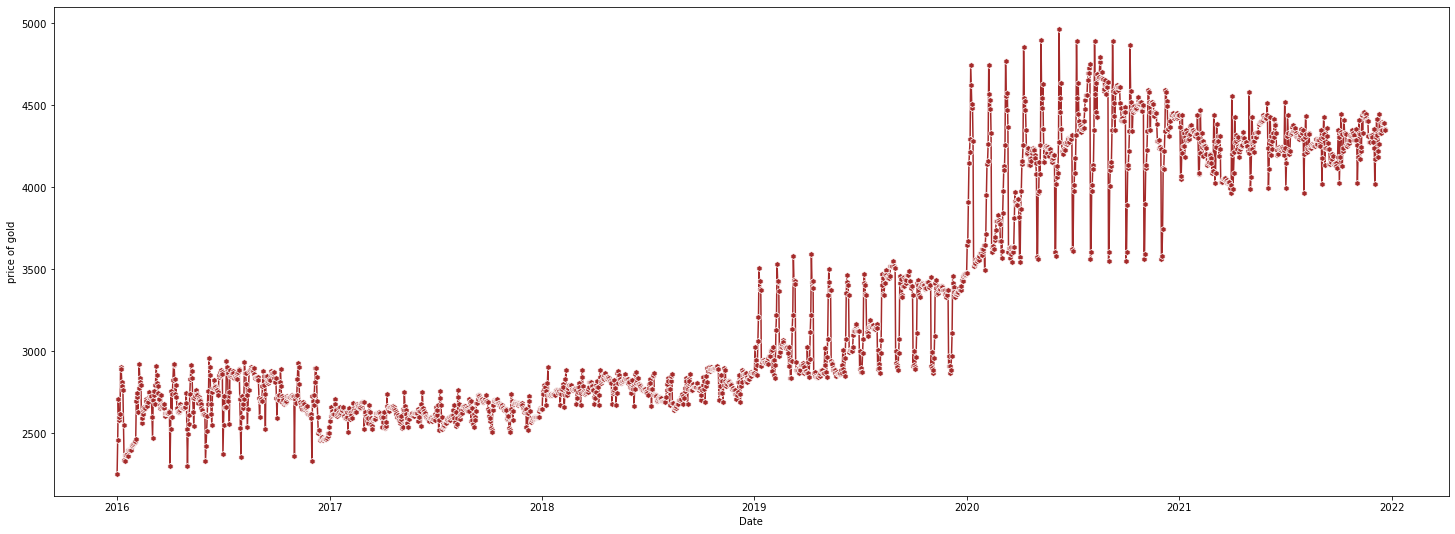

In [14]:
fig,ax=plt.subplots(figsize=(25,9))
plt.xlabel('Date')
plt.ylabel('price of gold')
sns.lineplot(x="date",y="price", data=data,color="brown",marker="h")

In [15]:
#Determine rolling statistics
rolmean = indexdata.rolling(window=12).mean() 
#window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexdata.rolling(window=12).std()
print(rolmean,rolstd)

                  price
date                   
2016-01-01          NaN
2016-01-02          NaN
2016-01-03          NaN
2016-01-04          NaN
2016-01-05          NaN
...                 ...
2021-12-17  4333.625000
2021-12-18  4331.616667
2021-12-19  4337.458333
2021-12-20  4351.841667
2021-12-21  4362.433333

[2182 rows x 1 columns]                 price
date                 
2016-01-01        NaN
2016-01-02        NaN
2016-01-03        NaN
2016-01-04        NaN
2016-01-05        NaN
...               ...
2021-12-17  79.471025
2021-12-18  77.547462
2021-12-19  79.166929
2021-12-20  62.094363
2021-12-21  46.274229

[2182 rows x 1 columns]


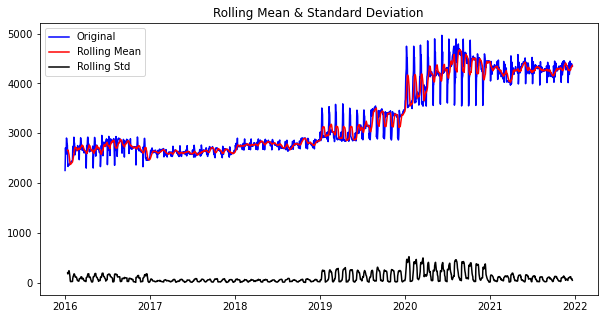

In [16]:
#Plot rolling statistics
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,5
orig = plt.plot(indexdata, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component #even though rolling standard deviation is fairly constant with time. For our #time series to be stationary, we need to ensure that both the rolling statistics #ie: mean & std. dev. remain time invariant or constant with time. Thus the #curves for both of them have to be parallel to the x-axis, which in our case is #not so.

#To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [17]:
#Perform Augmented Dickey–Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey Fuller Test:')
datatest = adfuller(indexdata['price'], autolag='AIC')

dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in datatest[4].items():
    dataoutput['Critical Value (%s)'%key] = value
    
print(dataoutput)

Results of Dickey Fuller Test:
Test Statistic                   -0.309904
p-value                           0.924090
#Lags Used                       26.000000
Number of Observations Used    2155.000000
Critical Value (1%)              -3.433388
Critical Value (5%)              -2.862882
Critical Value (10%)             -2.567484
dtype: float64


For a Time series to be stationary, its ADCF test should have:
p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large.
Also critical values are no where close to the Test Statistics. 
Hence, we can safely say that our Time Series at the moment is not stationary

## Data Transformation to achieve Stationarity <a name="data-transform"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence,  flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

### Log Scale Transformation  <a name="log"></a>

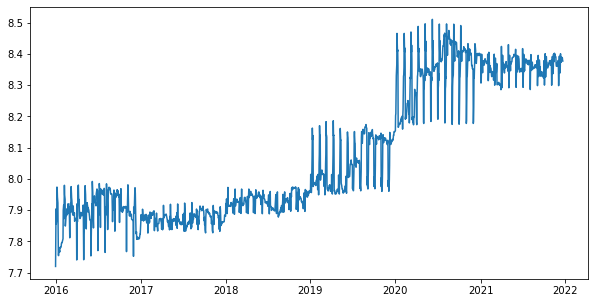

In [18]:
#Estimating trend
indexdata_logScale = np.log(indexdata)
plt.plot(indexdata_logScale)

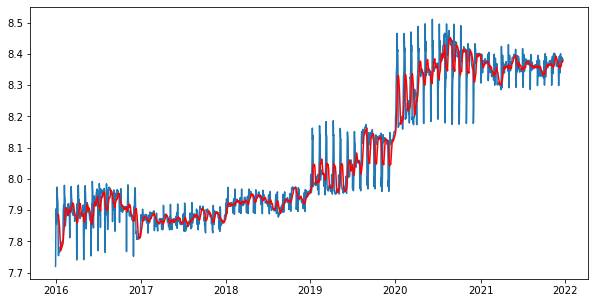

In [19]:
#The below transformation is required to make series stationary
movingAverage = indexdata_logScale.rolling(window=12).mean()
movingSTD = indexdata_logScale.rolling(window=12).std()
plt.plot(indexdata_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series.
We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐿=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐿1)+𝑡𝑟𝑒𝑛𝑑(𝐿𝑇) 
𝑚𝑜𝑣𝑖𝑛𝑔𝑎𝑣𝑔𝑜𝑓𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐴=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐴1)+𝑡𝑟𝑒𝑛𝑑(𝐴𝑇) 
𝑟𝑒𝑠𝑢𝑙𝑡𝑠𝑒𝑟𝑖𝑒𝑠𝑅=𝐿−𝐴=(𝐿1+𝐿𝑇)−(𝐴1+𝐴𝑇)=(𝐿1−𝐴1)+(𝐿𝑇−𝐴𝑇) 
Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

𝑅=𝐿1−𝐴1 , our final non-trend curve

In [20]:
dataLogScaleMinusMovingAverage = indexdata_logScale - movingAverage
dataLogScaleMinusMovingAverage.head(12)

#Remove NAN values
dataLogScaleMinusMovingAverage.dropna(inplace=True)
dataLogScaleMinusMovingAverage.head(10)

,price
date,
2016-01-12,-0.039877
2016-01-13,-0.130325
2016-01-14,-0.127601
2016-01-15,-0.101950
2016-01-16,-0.094308
2016-01-17,-0.086068
2016-01-18,-0.077235
2016-01-19,-0.064248
2016-01-20,-0.034024


In [21]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    datatest = adfuller(timeseries['price'], autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
        dataoutput['Critical Value (%s)'%key] = value
    print(dataoutput)
    

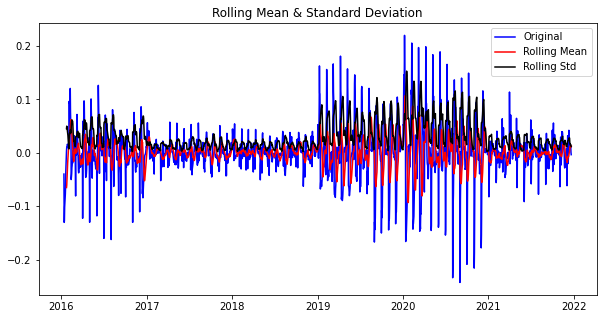

Results of Dickey Fuller Test:
Test Statistic                -1.493607e+01
p-value                        1.344003e-27
#Lags Used                     2.600000e+01
Number of Observations Used    2.144000e+03
Critical Value (1%)           -3.433404e+00
Critical Value (5%)           -2.862889e+00
Critical Value (10%)          -2.567488e+00
dtype: float64


In [22]:
test_stationarity(dataLogScaleMinusMovingAverage)

## Exponential Decay Transformation 

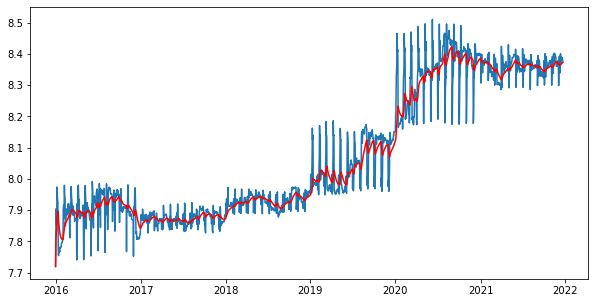

In [23]:
exponentialDecayWeightedAverage = indexdata_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexdata_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

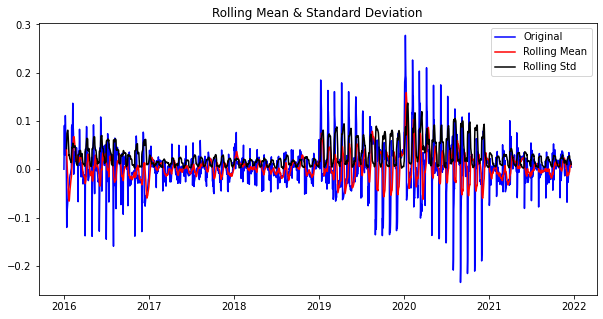

Results of Dickey Fuller Test:
Test Statistic                -8.814977e+00
p-value                        1.945338e-14
#Lags Used                     2.600000e+01
Number of Observations Used    2.155000e+03
Critical Value (1%)           -3.433388e+00
Critical Value (5%)           -2.862882e+00
Critical Value (10%)          -2.567484e+00
dtype: float64


In [24]:
datasetLogScaleMinusExponentialMovingAverage = indexdata_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

p-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.
But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
𝑥0,𝑥1,𝑥2,𝑥3,....𝑥𝑛 

The shifted values will be:
𝑛𝑢𝑙𝑙,𝑥0,𝑥1,𝑥2,....𝑥𝑛  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
𝑛𝑢𝑙𝑙,(𝑥1−𝑥0),(𝑥2−𝑥1),(𝑥3−𝑥2),(𝑥4−𝑥3),....(𝑥𝑛−𝑥𝑛−1)

# Time Shift Transformation

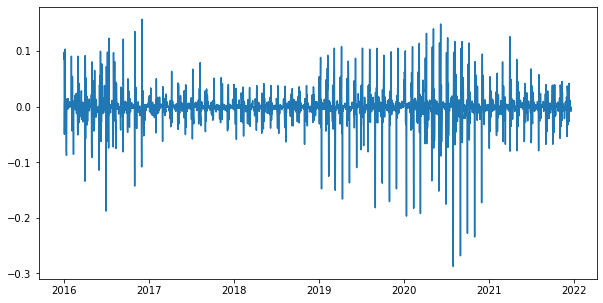

In [25]:
datasetLogDiffShifting = indexdata_logScale - indexdata_logScale.shift()
plt.plot(datasetLogDiffShifting)

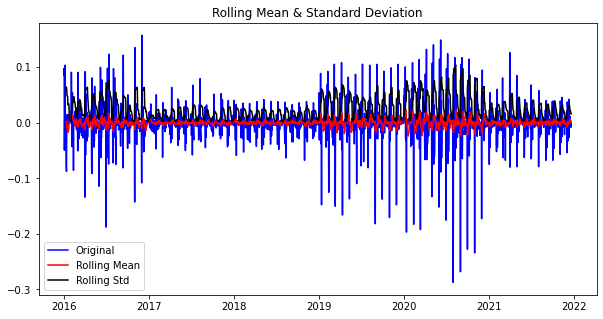

Results of Dickey Fuller Test:
Test Statistic                  -21.394232
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    2154.000000
Critical Value (1%)              -3.433390
Critical Value (5%)              -2.862883
Critical Value (10%)             -2.567485
dtype: float64


In [26]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

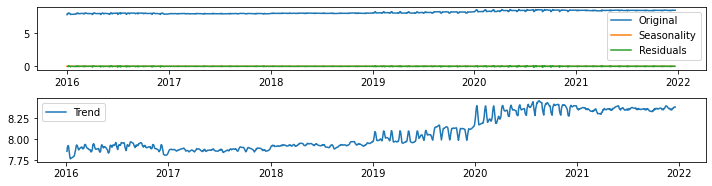

In [27]:
decomposition = seasonal_decompose(indexdata_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexdata_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.

## ACF plots and PACF plots

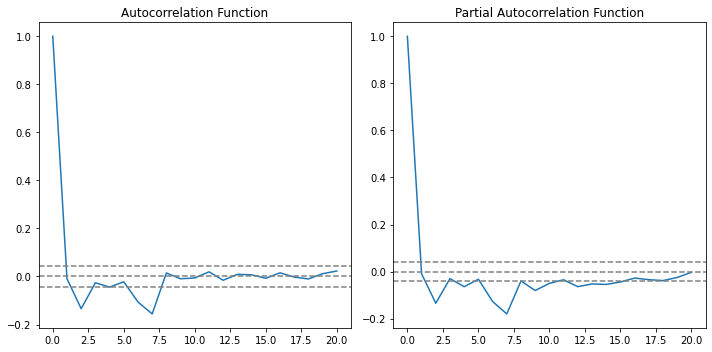

In [28]:
#ACF & PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. 
Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. 
Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. 
Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

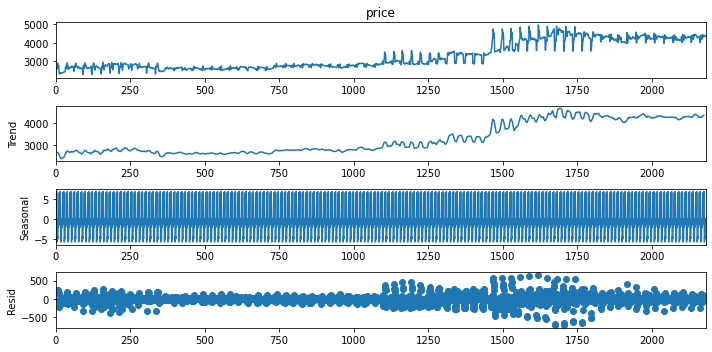

In [29]:
decompose_ts_add = seasonal_decompose(data.price,period=12)
decompose_ts_add.plot()
plt.show()

In [30]:
data["date"]=pd.to_datetime(data['date'])
data['months'] =data['date'].dt.strftime('%b')
data.head()

,date,price,months
0,2016-01-01,2252.60,Jan
1,2016-01-02,2454.50,Jan
2,2016-01-03,2708.10,Jan
3,2016-01-04,2577.80,Jan
4,2016-01-05,2597.75,Jan


In [31]:
month_dummies = pd.DataFrame(pd.get_dummies(data['months']))
data1 = pd.concat([data,month_dummies],axis = 1)
data1.head()

,date,price,months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2016-01-01,2252.60,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,2016-01-02,2454.50,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2,2016-01-03,2708.10,Jan,0,0,0,0,1,0,0,0,0,0,0,0
3,2016-01-04,2577.80,Jan,0,0,0,0,1,0,0,0,0,0,0,0
4,2016-01-05,2597.75,Jan,0,0,0,0,1,0,0,0,0,0,0,0


In [32]:
data1["t"] = np.arange(1,2183)
data1["t_squared"] = data1["t"]*data1["t"]
data1["log_price"] = np.log(data1["price"])
data1.columns
data1.head()

,date,price,months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_price
0,2016-01-01,2252.60,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,7.719840
1,2016-01-02,2454.50,Jan,0,0,0,0,1,0,0,0,0,0,0,0,2,4,7.805678
2,2016-01-03,2708.10,Jan,0,0,0,0,1,0,0,0,0,0,0,0,3,9,7.904003
3,2016-01-04,2577.80,Jan,0,0,0,0,1,0,0,0,0,0,0,0,4,16,7.854692
4,2016-01-05,2597.75,Jan,0,0,0,0,1,0,0,0,0,0,0,0,5,25,7.862401


In [33]:
Train = data1.head(1527)
Test = data1.tail(654)

In [34]:
# Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('price~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['price'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  872.527149408394


In [35]:
# Exponential Model
Exp = smf.ols('log_price~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['price'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  869.6865248644767


In [36]:
# Qudtractic model
Quad = smf.ols('price~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['price'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  520.4983258502107


In [37]:
# Additive Seasonality
add_sea = smf.ols('price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['price'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1456.5589089007915


In [38]:
# Additive Seasonality Quadratic
add_sea_Quad = smf.ols('price~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['price'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 504.0212122192574


In [39]:
# Multiplicative Seasonality
Mul_sea = smf.ols('log_price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['price'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 1469.524340961715


In [40]:
# Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_price~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['price'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 879.0303560888821


In [41]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,872.527149
1,rmse_Exp,869.686525
2,rmse_Quad,520.498326
3,rmse_add_sea,1456.558909
4,rmse_add_sea_quad,504.021212
5,rmse_Mult_sea,1469.524341
6,rmse_Mult_add_sea,879.030356


## Building Models

Plotting AR model


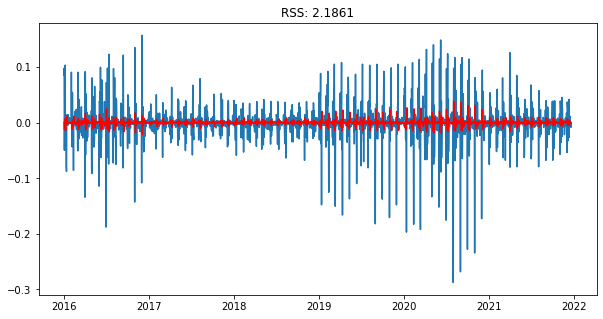

In [42]:
from statsmodels.tsa.arima_model import ARIMA
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexdata_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['price'])**2))
print('Plotting AR model')

In [43]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2181
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4435.790
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 03 May 2022   AIC                          -8863.579
Time:                        15:28:40   BIC                          -8840.829
Sample:                    01-02-2016   HQIC                         -8855.263
                         - 12-21-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.493      0.622      -0.001       0.001
ar.L1.D.price    -0.0112      0.021     -0.526      0.599      -0.053       0.030
ar.L2.D.price    -0.1353      0.021     

Plotting MA model


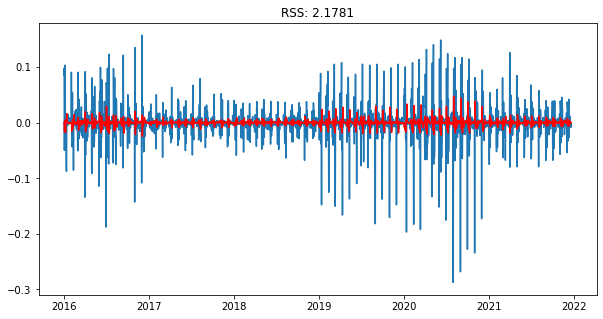

In [44]:
#MA Model
model = ARIMA(indexdata_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['price'])**2))
print('Plotting MA model')

In [45]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2181
Model:                 ARIMA(0, 1, 2)   Log Likelihood                4439.863
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 03 May 2022   AIC                          -8871.726
Time:                        15:28:40   BIC                          -8848.975
Sample:                    01-02-2016   HQIC                         -8863.409
                         - 12-21-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.527      0.598      -0.001       0.001
ma.L1.D.price    -0.0281      0.022     -1.288      0.198      -0.071       0.015
ma.L2.D.price    -0.1662      0.024     

Plotting ARIMA model


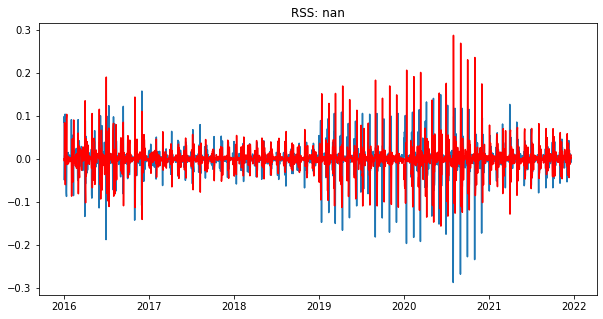

In [46]:
# AR+I+MA = ARIMA model
model = ARIMA(indexdata_logScale, order=(2,2,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['price'])**2))
print('Plotting ARIMA model')

In [47]:
print(results_ARIMA .summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 2180
Model:                 ARIMA(2, 2, 2)   Log Likelihood                4427.844
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 03 May 2022   AIC                          -8843.687
Time:                        15:28:42   BIC                          -8809.565
Sample:                    01-03-2016   HQIC                         -8831.213
                         - 12-21-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.135e-08   1.05e-06     -0.049      0.961   -2.11e-06    2.01e-06
ar.L1.D2.price    -0.0789      0.328     -0.240      0.810      -0.722       0.565
ar.L2.D2.price    -0.1554      0.024

## Prediction & Reverse transformations 

In [48]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2016-01-03   -5.134957e-08
2016-01-04   -5.314262e-03
2016-01-05    8.368270e-02
2016-01-06    4.180288e-02
2016-01-07    2.202200e-02
dtype: float64


In [49]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

date
2016-01-03   -5.134957e-08
2016-01-04   -5.314313e-03
2016-01-05    7.836838e-02
2016-01-06    1.201713e-01
2016-01-07    1.421933e-01
                  ...     
2021-12-17    7.232029e-01
2021-12-18    7.229635e-01
2021-12-19    7.246839e-01
2021-12-20    7.251114e-01
2021-12-21    7.335048e-01
Length: 2180, dtype: float64


In [50]:
predictions_ARIMA_log = pd.Series(indexdata_logScale['price'].iloc[0], index=indexdata_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2016-01-01    7.719840
2016-01-02    7.719840
2016-01-03    7.719840
2016-01-04    7.714526
2016-01-05    7.798209
dtype: float64

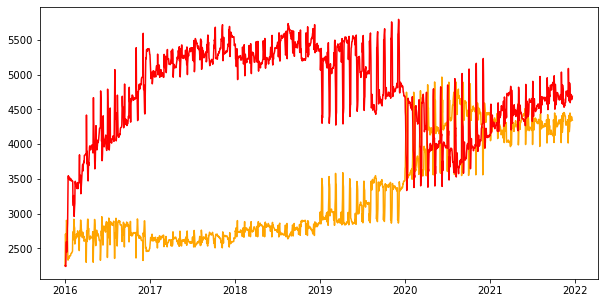

In [51]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexdata,color='orange')
plt.plot(predictions_ARIMA,color='red')

In [52]:
indexdata_logScale

,price
date,
2016-01-01,7.719840
2016-01-02,7.805678
2016-01-03,7.904003
2016-01-04,7.854692
2016-01-05,7.862401
...,...
2021-12-17,8.388086
2021-12-18,8.386971
2021-12-19,8.386971


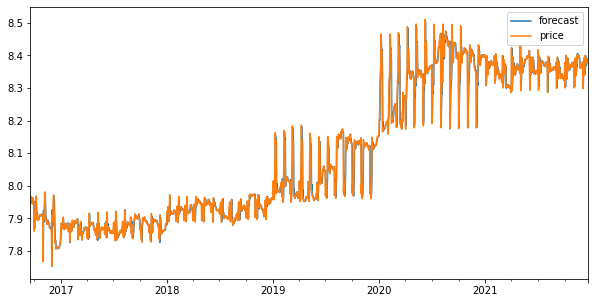

In [53]:
#We have 2182 data points. 
#And we want to forecast for additional 30 data points 
results_ARIMA.plot_predict(261,1) 
x=results_ARIMA.forecast(steps=30)

In [54]:
print(x[1])
print(len(x[1]))
print(np.exp(x[1]))

[0.03169419 0.04474049 0.05209574 0.05873057 0.06500676 0.07068851
 0.07591577 0.08082176 0.08545764 0.08985925 0.09406054 0.09808802
 0.10196209 0.10569954 0.1093144  0.11281849 0.11622181 0.11953299
 0.12275948 0.12590778 0.12898365 0.13199213 0.13493774 0.13782451
 0.14065607 0.1434357  0.14616635 0.14885073 0.1514913  0.15409031]
30
[1.0322018  1.04575644 1.0534766  1.06048947 1.06716624 1.07324687
 1.07887169 1.08417764 1.08921542 1.09402029 1.09862625 1.10305987
 1.1073415  1.11148786 1.11551301 1.11942873 1.123245   1.12697042
 1.13061245 1.13417757 1.13767152 1.14109933 1.14446552 1.14777411
 1.15102871 1.15423259 1.1573887  1.16049975 1.16356817 1.16659623]


In [55]:
# Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [56]:
# Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
# Holt method 
hw_model = Holt(Train["price"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.price) 

443.3295938331491

In [57]:
### Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["price"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.price)

224.87539569244677

In [58]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend¶
hwe_model_mul_add = ExponentialSmoothing(Train["price"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.price)

70.02394096333877

In [59]:
# Final Model by combining train and test
hwe_model_add_add = ExponentialSmoothing(data["price"],seasonal="add",trend="add",seasonal_periods=12).fit()

In [60]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(30)

2182    4404.489550
2183    4418.578259
2184    4357.762301
2185    4316.561672
2186    4273.491615
2187    4311.449096
2188    4391.194715
2189    4421.372732
2190    4386.296510
2191    4366.507972
2192    4348.067463
2193    4373.509616
2194    4422.537571
2195    4436.626280
2196    4375.810322
2197    4334.609693
2198    4291.539636
2199    4329.497117
2200    4409.242736
2201    4439.420753
2202    4404.344531
2203    4384.555993
2204    4366.115484
2205    4391.557637
2206    4440.585592
2207    4454.674301
2208    4393.858343
2209    4352.657714
2210    4309.587657
2211    4347.545138
dtype: float64